In [1]:
import os
import itertools as it
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set("talk", style="white")

from copy import deepcopy as copy
from tqdm import tqdm
from astropy.io import fits
from astropy.coordinates import SkyCoord
from astropy.visualization import make_lupton_rgb
from astropy import units as u

from reproject import reproject_interp
from reproject.mosaicking import reproject_and_coadd
from reproject.mosaicking import find_optimal_celestial_wcs
from astropy.wcs import WCS

from pyFIT3D.common.io import get_wave_from_header
from pyFIT3D.common.tools import rss_seg2cube
from lvmdap.analysis.stats import weighted_pdf
from lvmdap.analysis.stats import normalize_to_pdf, get_nth_moment, get_nth_percentile

import warnings
warnings.filterwarnings("ignore")

In [2]:
CUBE_PATTERN = ".cube.fits.gz"

G_WAVE = 4672-500, 4672+500
R_WAVE = 6141-500, 6141+500
I_WAVE = 7458-500, 7458+500

plates = [9673, 9674, 9675]+list(range(10141, 10151)) + \
    list(range(10480, 10492))+list(range(12027, 12051))
ifus = [9101, 9102, 12701, 12702, 12703, 12704, 12705]

MANGA_NAME = "manga-{}-{}-moments.cube.fits.gz"
names = []
for plate, ifu in it.product(plates, ifus):
    names.append(MANGA_NAME.format(plate,ifu))

In [3]:
POINTING = "manga-9673-9101"
# POINTING = "manga-10146-12704"

PRODUCTS_PATH = "../../_fitting-data/IC342"
OUTPUT_PATH = os.path.join(PRODUCTS_PATH, "out")
# OUTPUT_PATH = "_data/ic342/out"
RSP_PARAMS_PATH = '../../_fitting-data/_basis_mastar_v2/stellar-basis-params-100.fits.gz'

PARAM_NAMES = "TEFF LOGG MET ALPHAM".split()

WAVE_NORM = 5400, 5600

# read RSS output file
out_rss = fits.open(os.path.join(OUTPUT_PATH,f"output.{POINTING}.fits.gz"), memmap=False)
# out_rss.info()
# read segmentation map
seg_map__yx = fits.getdata(os.path.join(PRODUCTS_PATH, "preprocessed", f"cont_seg.{POINTING}.fits.gz"))
# read coefficients table
model = pd.read_csv(os.path.join(OUTPUT_PATH,f"coeffs_{POINTING}"), sep="\s+")
model.columns = model.columns[1:].tolist()+["#"]
model.drop(columns="#", inplace=True)
# model
# read RSP models
rsp_params = fits.open(RSP_PARAMS_PATH, memmap=False)
# rsp_params.info()
# read/calculate dezonification map
dez_map__yx = fits.getdata(os.path.join(OUTPUT_PATH,f"{POINTING}-dezonification.map.fits.gz"))
# compute PDF for physical properties
nclusters = rsp_params[0].header["NCLUSTER"]
nvoxels = model.shape[0]//nclusters
nproj = len(rsp_params) - 1
voxel_pdfs = {name: [] for name in PARAM_NAMES}
voxel_supp = dict.fromkeys(PARAM_NAMES)
for ivoxel in range(nvoxels):
    pending_param = copy(PARAM_NAMES)
    for ihdu in range(1,nproj+1):
        wPDF, x_scale, y_scale = weighted_pdf(
            rsp_params,
            ihdu,
            coeffs=model.COEFF.values[nclusters*ivoxel:nclusters*(ivoxel+1)]
        )
        if voxel_supp[rsp_params[ihdu].header["CTYPE1"]] is None: voxel_supp[rsp_params[ihdu].header["CTYPE1"]] = x_scale
        if voxel_supp[rsp_params[ihdu].header["CTYPE2"]] is None: voxel_supp[rsp_params[ihdu].header["CTYPE2"]] = y_scale
        if rsp_params[ihdu].header["CTYPE1"] in pending_param:
            mPDF = (wPDF*rsp_params[ihdu].header["CDELT2"]).sum(axis=0)
            voxel_pdfs[rsp_params[ihdu].header["CTYPE1"]].append(normalize_to_pdf(mPDF, x_scale))
            pending_param.remove(rsp_params[ihdu].header["CTYPE1"])
        if rsp_params[ihdu].header["CTYPE2"] in pending_param:
            mPDF = (wPDF*rsp_params[ihdu].header["CDELT1"]).sum(axis=1)
            voxel_pdfs[rsp_params[ihdu].header["CTYPE2"]].append(normalize_to_pdf(mPDF, y_scale))
            pending_param.remove(rsp_params[ihdu].header["CTYPE2"])
# compute momenta from PDFs
#  - compute luminosity weights
rsp_mod = fits.open(os.path.join(OUTPUT_PATH,f"{POINTING}-rsp.cube.fits.gz"), memmap=False)
rsp_mod_cube__wyx = rsp_mod[0].data
rsp_wave__w = get_wave_from_header(rsp_mod[0].header, wave_axis=3)
mask_norm = (WAVE_NORM[0]<=rsp_wave__w)&(rsp_wave__w<=WAVE_NORM[1])
lum_band = np.nanmedian(rsp_mod_cube__wyx[mask_norm], axis=0)
lum_band /= np.nansum(lum_band)
#  - compute PDF cubes
cube_pdfs = {name: rss_seg2cube(np.asarray(voxel_pdfs[name]), seg_map__yx)*lum_band[None] for name in PARAM_NAMES}
# build moment maps
moments = {name: np.zeros_like(seg_map__yx, dtype=float) for name in PARAM_NAMES}
ny, nx = seg_map__yx.shape
for name in PARAM_NAMES:
    for iy, ix in list(zip(*np.where(seg_map__yx!=0))):
        # moments[name][iy,ix] = get_nth_moment(voxel_supp[name], cube_pdfs[name][:,iy,ix], nth=1)
        moments[name][iy,ix] = get_nth_percentile(voxel_supp[name], normalize_to_pdf(cube_pdfs[name][:,iy,ix], voxel_supp[name]), percent=50)

In [4]:
# # bad_idx = np.argmin(np.abs(
# #     ic342_coords-np.asarray([[bad_coords.ra.value, bad_coords.dec.value]])).sum(axis=1))

# gas_cube_paths = sorted([os.path.join(root, file) for root, _, files in os.walk(OUTPUT_PATH) for file in files if file.endswith(CUBE_PATTERN) and file in names])

# cube_path = gas_cube_paths[7]
# print(os.path.basename(cube_path.replace("-moments.cube.fits.gz", "")))

# gas_cube = fits.getdata(cube_path.replace("out", "out"))[:4]

# mask_img = (np.nan_to_num(gas_cube, posinf=0, neginf=0) > 0).any(axis=0)

# # compute gri-band image of each cube
# g_image = gas_cube[0]
# g_image[~mask_img] = np.nan
# r_image = gas_cube[2]
# r_image[~mask_img] = np.nan
# i_image = gas_cube[3]
# i_image[~mask_img] = np.nan

# rgb_gas_bad = make_lupton_rgb(i_image, r_image, g_image, stretch=0.5, Q=5)
# plt.imshow(rgb_gas_bad, origin="lower")
# # plt.colorbar()

In [5]:
# org_cube__wyx = fits.getdata(os.path.join(PRODUCTS_PATH, "obs", f"{POINTING}.cube.fits.gz"))
# obs_lum_band = np.nanmedian(org_cube__wyx[mask_norm], axis=0)

# plt.figure(figsize=(10,10))
# plt.imshow(np.ma.masked_array(obs_lum_band, mask=seg_map__yx==0), origin="lower")

In [6]:
# plt.figure(figsize=(10,10))
# plt.imshow(np.ma.masked_array(lum_band, mask=seg_map__yx==0), origin="lower")

In [7]:
# plt.figure(figsize=(10,10))
# plt.imshow(np.ma.masked_array(moments["LOGG"], mask=seg_map__yx==0), origin="lower", cmap="rainbow")
# plt.colorbar()

In [8]:
MANGA_NAME = "manga-{}-{}.cube.fits.gz"
names = []
for plate, ifu in it.product(plates, ifus):
    names.append(MANGA_NAME.format(plate,ifu))

org_cube_paths = sorted([os.path.join(root,file) for root, _, files in os.walk(os.path.join(PRODUCTS_PATH,"cubes")) for file in files if file.endswith(CUBE_PATTERN) and file in names])

hdus, headers = [], []
for icube, org_cube_path in tqdm(enumerate(org_cube_paths), total=len(org_cube_paths), desc="extracting gri-band image", unit="cube", ascii=True):

    label = os.path.basename(org_cube_path).replace(CUBE_PATTERN,"")

    if label == POINTING: ipointing = icube

    # read IC342 original cube
    org_cube = fits.open(org_cube_path, memmap=False)
    org_cube__wyx, org_header = org_cube[0].data, org_cube[0].header
    org_wave__w = get_wave_from_header(org_header, wave_axis=3)

    mask_img = (np.nan_to_num(org_cube__wyx)!=0).any(axis=0)

    # compute gri-band image of each cube
    g_image = np.nanmedian(org_cube__wyx[(G_WAVE[0]<=org_wave__w)&(org_wave__w<=G_WAVE[1])], axis=0)
    g_image[~mask_img] = np.nan
    r_image = np.nanmedian(org_cube__wyx[(R_WAVE[0]<=org_wave__w)&(org_wave__w<=R_WAVE[1])], axis=0)
    r_image[~mask_img] = np.nan
    i_image = np.nanmedian(org_cube__wyx[(I_WAVE[0]<=org_wave__w)&(org_wave__w<=I_WAVE[1])], axis=0)
    i_image[~mask_img] = np.nan

    new_header = copy(org_header)
    del new_header["*3"]
    del new_header["PLATEID"]
    del new_header["DATE-OBS"]
    hdu_g = fits.ImageHDU(data=g_image, header=new_header)
    hdu_r = fits.ImageHDU(data=r_image, header=new_header)
    hdu_i = fits.ImageHDU(data=i_image, header=new_header)
    hdus.append((hdu_g,hdu_r,hdu_i))
    headers.append(new_header)

extracting gri-band image: 100%|##########| 342/342 [14:43<00:00,  2.58s/cube]


In [9]:
# build mosaic
reference_coord = SkyCoord.from_name("IC342")

g_hdus, r_hdus, i_hdus = list(zip(*hdus))
wcs_out, shape_out = find_optimal_celestial_wcs(g_hdus, reference=reference_coord)

g_pointing = copy(g_hdus[ipointing].data)
r_pointing = copy(r_hdus[ipointing].data)
i_pointing = copy(i_hdus[ipointing].data)

# g_hdus[ipointing].data = np.ones_like(g_hdus[ipointing].data)*999
# g_hdus[ipointing].data[~mask_img] = np.nan
# r_hdus[ipointing].data = np.ones_like(r_hdus[ipointing].data)*999
# r_hdus[ipointing].data[~mask_img] = np.nan
# i_hdus[ipointing].data = np.ones_like(i_hdus[ipointing].data)*999
# i_hdus[ipointing].data[~mask_img] = np.nan

g_mosaic, _ = reproject_and_coadd(g_hdus, wcs_out, shape_out=shape_out, reproject_function=reproject_interp)
r_mosaic, _ = reproject_and_coadd(r_hdus, wcs_out, shape_out=shape_out, reproject_function=reproject_interp)
i_mosaic, _ = reproject_and_coadd(i_hdus, wcs_out, shape_out=shape_out, reproject_function=reproject_interp)

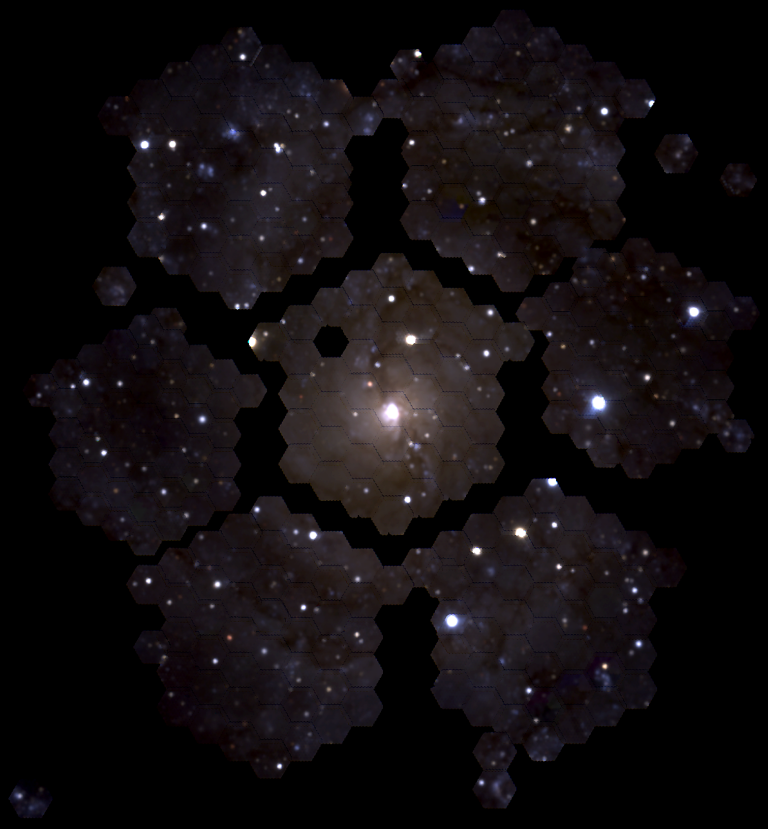

In [49]:
from PIL import Image, ImageEnhance
from lvmdap.analysis import img_scale


def create_RGB(Rdata, Gdata, Bdata):
    scale_flux = 0.7  # 2.5
    RGBdata = np.zeros((Bdata.shape[0], Bdata.shape[1], 3), dtype=float)
    RGBdata[:, :, 0] = img_scale.sqrt(
        Rdata*scale_flux * 1.2, scale_min=0.01, scale_max=2)
    RGBdata[:, :, 1] = img_scale.sqrt(
        Gdata*scale_flux * 0.9, scale_min=0.01, scale_max=2)
    RGBdata[:, :, 2] = img_scale.sqrt(
        Bdata*scale_flux * 1.1, scale_min=0.01, scale_max=2)

    RGBdata = RGBdata * 255
    RGBdata_int = RGBdata.astype('uint8')

    RGB_image = Image.fromarray(RGBdata_int)

    bright = ImageEnhance.Brightness(RGB_image)
    RGB_image = bright.enhance(1.2)
    contrast = ImageEnhance.Contrast(RGB_image)
    RGB_image = contrast.enhance(1.5)
    sharpness = ImageEnhance.Sharpness(RGB_image)
    RGB_image = sharpness.enhance(2.0)

    return RGB_image.__array__()


# rgb_mosaic = make_lupton_rgb(i_mosaic, r_mosaic, g_mosaic, stretch=0.5, Q=5)
rgb_mosaic = create_RGB(i_mosaic, r_mosaic, g_mosaic)

fig, ax = plt.subplots(figsize=(15,15), subplot_kw={'projection': wcs_out})
ax.set_aspect("equal")
ax.imshow(rgb_mosaic, origin="lower")
ax.tick_params("x", bottom=False, top=False)
ax.tick_params("y", left=False, right=False)
ax.axis("off")
fig.set_facecolor("#000")

# compute Halpha image of each cube
# overlay contours of Halpha on mosaic

In [26]:
CUBE_PATTERN = "-rsp.cube.fits.gz"

G_WAVE = 4672-500, 4672+500
R_WAVE = 6141-500, 6141+500
I_WAVE = 7458-500, 7458+500

plates = [9673, 9674, 9675]+list(range(10141, 10151)) + \
    list(range(10480, 10492))+list(range(12027, 12051))
ifus = [9101, 9102, 12701, 12702, 12703, 12704, 12705]

MANGA_NAME = "manga-{}-{}-rsp.cube.fits.gz"
names = []
for plate, ifu in it.product(plates, ifus):
    names.append(MANGA_NAME.format(plate, ifu))

rsp_cube_paths = sorted([os.path.join(root, file) for root, _, files in os.walk(OUTPUT_PATH) for file in files if file.endswith(CUBE_PATTERN) and file in names])

rsp_hdus = []
for icube, rsp_cube_path in tqdm(enumerate(rsp_cube_paths), total=len(rsp_cube_paths), desc="extracting gri-band image", unit="cube", ascii=True):

    # read IC342 original cube
    rsp_cube = fits.open(rsp_cube_path, memmap=False)
    rsp_cube__wyx, rsp_header = rsp_cube[0].data, rsp_cube[0].header
    rsp_wave__w = get_wave_from_header(rsp_header, wave_axis=3)

    mask_img = (np.nan_to_num(rsp_cube__wyx) > 0).any(axis=0)

    # compute gri-band image of each cube
    g_image = np.nanmedian(
        rsp_cube__wyx[(G_WAVE[0] <= rsp_wave__w) & (rsp_wave__w <= G_WAVE[1])], axis=0)
    g_image[~mask_img] = np.nan
    r_image = np.nanmedian(
        rsp_cube__wyx[(R_WAVE[0] <= rsp_wave__w) & (rsp_wave__w <= R_WAVE[1])], axis=0)
    r_image[~mask_img] = np.nan
    i_image = np.nanmedian(
        rsp_cube__wyx[(I_WAVE[0] <= rsp_wave__w) & (rsp_wave__w <= I_WAVE[1])], axis=0)
    i_image[~mask_img] = np.nan

    hdu_g = fits.ImageHDU(data=g_image, header=headers[icube])
    hdu_r = fits.ImageHDU(data=r_image, header=headers[icube])
    hdu_i = fits.ImageHDU(data=i_image, header=headers[icube])
    rsp_hdus.append((hdu_g, hdu_r, hdu_i))

extracting gri-band image: 100%|##########| 342/342 [13:39<00:00,  2.40s/cube]


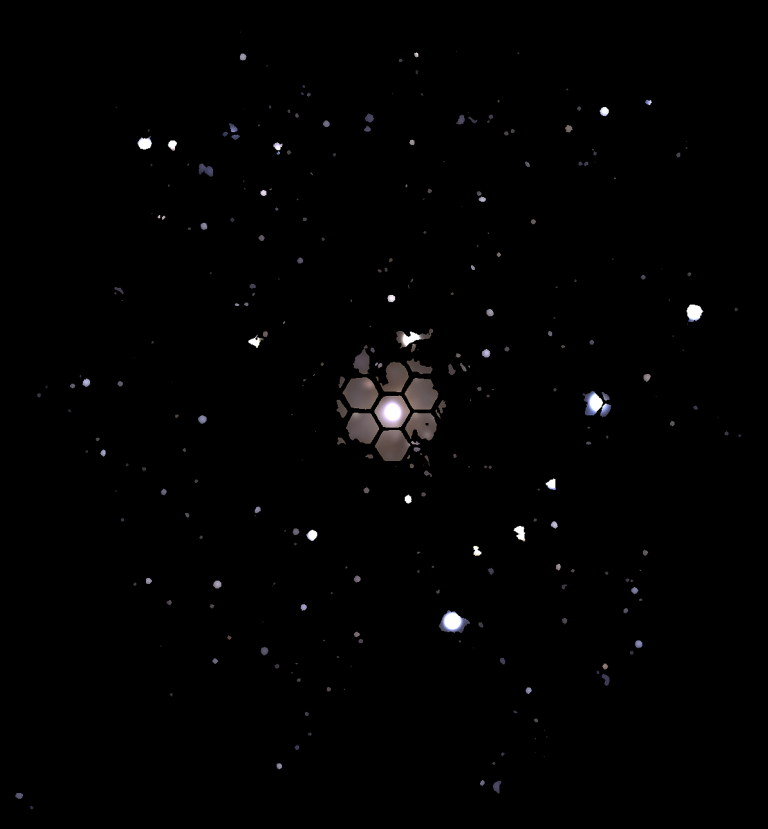

In [50]:
# build mosaic
reference_coord = SkyCoord.from_name("IC342")

g_rsp_hdus, r_rsp_hdus, i_rsp_hdus = list(zip(*rsp_hdus))
wcs_out, shape_out = find_optimal_celestial_wcs(
    g_rsp_hdus, reference=reference_coord)

g_rsp_mosaic, _ = reproject_and_coadd(
    g_rsp_hdus, wcs_out, shape_out=shape_out, reproject_function=reproject_interp)
r_rsp_mosaic, _ = reproject_and_coadd(
    r_rsp_hdus, wcs_out, shape_out=shape_out, reproject_function=reproject_interp)
i_rsp_mosaic, _ = reproject_and_coadd(
    i_rsp_hdus, wcs_out, shape_out=shape_out, reproject_function=reproject_interp)


# rgb_rsp_mosaic = make_lupton_rgb(i_rsp_mosaic, r_rsp_mosaic, g_rsp_mosaic, stretch=0.5, Q=5)
rgb_rsp_mosaic = create_RGB(i_rsp_mosaic, r_rsp_mosaic, g_rsp_mosaic)

fig, ax = plt.subplots(figsize=(15, 15), subplot_kw={'projection': wcs_out})
ax.set_aspect("equal")
ax.imshow(rgb_rsp_mosaic, origin="lower")
ax.tick_params("x", bottom=False, top=False)
ax.tick_params("y", left=False, right=False)
ax.axis("off")
fig.set_facecolor("#000")


In [28]:
CUBE_PATTERN = "-moments.cube.fits.gz"

plates = [9673, 9674, 9675]+list(range(10141,10151))+list(range(10480,10492))+list(range(12027,12051))
ifus = [9101, 9102, 12701, 12702, 12703, 12704, 12705]

MANGA_NAME = "manga-{}-{}-moments.cube.fits.gz"
names = []
for plate, ifu in it.product(plates, ifus):
    names.append(MANGA_NAME.format(plate,ifu))

gas_cube_paths = sorted([os.path.join(root,file) for root, _, files in os.walk(OUTPUT_PATH) for file in files if file.endswith(CUBE_PATTERN) and file in names])

gas_hdus = []
for icube, gas_cube_path in tqdm(enumerate(gas_cube_paths), total=len(gas_cube_paths), desc="extracting gri-band image", unit="cube", ascii=True):

    # read IC342 original cube
    gas_cube = fits.getdata(gas_cube_path)[:4]

    mask_img = (np.nan_to_num(gas_cube, posinf=0, neginf=0)>0).any(axis=0)

    # compute gri-band image of each cube
    g_image = gas_cube[0]
    g_image[~mask_img] = np.nan
    r_image = gas_cube[2]
    r_image[~mask_img] = np.nan
    i_image = gas_cube[3]
    i_image[~mask_img] = np.nan

    hdu_g = fits.ImageHDU(data=g_image, header=headers[icube])
    hdu_r = fits.ImageHDU(data=r_image, header=headers[icube])
    hdu_i = fits.ImageHDU(data=i_image, header=headers[icube])
    gas_hdus.append((hdu_g,hdu_r,hdu_i))

extracting gri-band image: 100%|##########| 342/342 [00:11<00:00, 31.00cube/s]


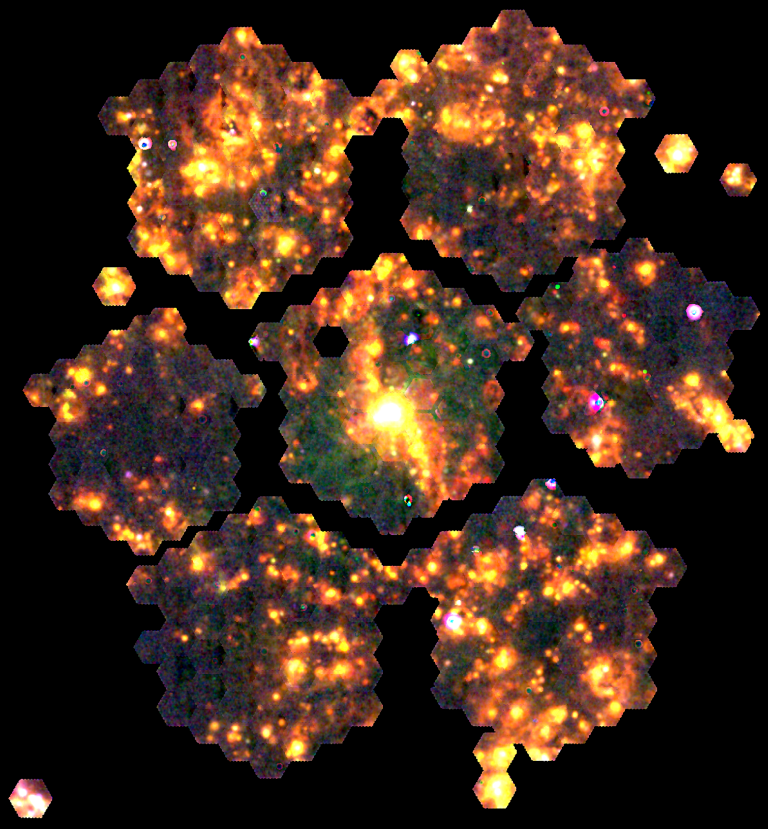

In [53]:
from matplotlib.ticker import MultipleLocator
from scipy.ndimage import gaussian_filter

# build mosaic
reference_coord = SkyCoord.from_name("IC342")

g_gas_hdus, r_gas_hdus, i_gas_hdus = list(zip(*gas_hdus))
wcs_out, shape_out = find_optimal_celestial_wcs(
    g_gas_hdus, reference=reference_coord)

g_gas_mosaic, _ = reproject_and_coadd(
    g_gas_hdus, wcs_out, shape_out=shape_out, reproject_function=reproject_interp)
r_gas_mosaic, _ = reproject_and_coadd(
    r_gas_hdus, wcs_out, shape_out=shape_out, reproject_function=reproject_interp)
i_gas_mosaic, _ = reproject_and_coadd(
    i_gas_hdus, wcs_out, shape_out=shape_out, reproject_function=reproject_interp)


# rgb_gas_mosaic = make_lupton_rgb(
#     i_gas_mosaic,
#     r_gas_mosaic,
#     g_gas_mosaic,
#     stretch=1.0, Q=5)
rgb_gas_mosaic = create_RGB(
    r_gas_mosaic,
    i_gas_mosaic,
    g_gas_mosaic
)


fig, ax = plt.subplots(figsize=(15, 15), subplot_kw={'projection': wcs_out})
ax.set_aspect("equal")
ax.imshow(rgb_gas_mosaic, origin="lower")
ax.tick_params("x", bottom=False, top=False)
ax.tick_params("y", left=False, right=False)
ax.axis("off")
fig.set_facecolor("#000")

In [54]:
# # locate good and bad pointings
# ic342_coords = []
# for icube, org_cube_path in tqdm(enumerate(org_cube_paths), total=len(org_cube_paths), desc="extracting header", unit="cube", ascii=True):
#     label = os.path.basename(org_cube_path).replace(CUBE_PATTERN, "")

#     # read IC342 original cube
#     org_header = fits.getheader(org_cube_path)
#     ic342_coords.append((org_header["OBJRA"], org_header["OBJDEC"]))
# ic342_coords = np.asarray(ic342_coords)

In [55]:
# good_coords = SkyCoord(ra="3 46 30", dec="68 03 00", unit=(u.hourangle, u.deg))
# bad_coords = SkyCoord(ra="3 47 00", dec="68 06 00", unit=(u.hourangle, u.deg))

In [56]:
# good_idx = np.argmin(np.abs(
#     ic342_coords-np.asarray([[good_coords.ra.value, good_coords.dec.value]])).sum(axis=1))

# gas_cube = fits.getdata(
#     gas_cube_paths[good_idx].replace("out", "out"))[:4]

# mask_img = (np.nan_to_num(gas_cube, posinf=0, neginf=0) > 0).any(axis=0)

# # compute gri-band image of each cube
# g_image = gas_cube[0]
# g_image[~mask_img] = np.nan
# r_image = gas_cube[2]
# r_image[~mask_img] = np.nan
# i_image = gas_cube[3]
# i_image[~mask_img] = np.nan

# rgb_gas_good = make_lupton_rgb(
#     i_image, r_image, g_image, stretch=0.5, Q=5)
# plt.imshow(rgb_gas_good, origin="lower")


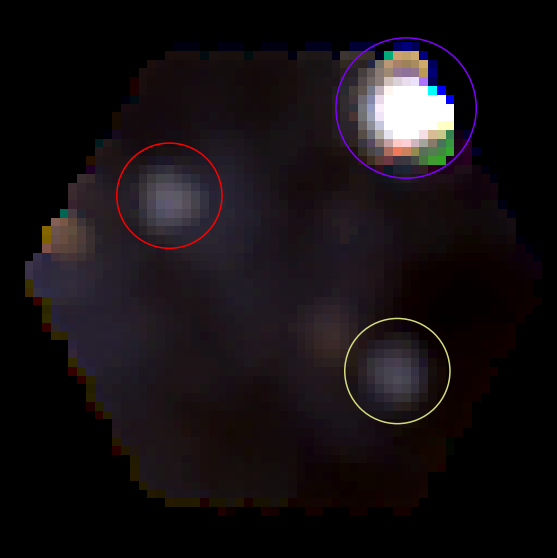

In [57]:
from matplotlib.patches import Circle


# rgb_pointing = make_lupton_rgb(i_pointing, r_pointing, g_pointing, stretch=0.5, Q=5)
rgb_pointing = create_RGB(i_pointing, r_pointing, g_pointing)

fig, ax = plt.subplots(figsize=(10,10))
ax.set_aspect("equal")
ax.imshow(rgb_pointing, origin="lower")

spaxels = np.column_stack(np.where(seg_map__yx!=0))

region_a = Circle((45,50), 8, fc="none", ec="#7F00FF")
region_b = Circle((18,40), 6, fc="none", ec="#FF0000")
region_c = Circle((44,20), 6, fc="none", ec="#D4DC7F")
mask_a = region_a.contains_points(spaxels)
mask_b = region_b.contains_points(spaxels)
mask_c = region_c.contains_points(spaxels)

masks = [mask_a,mask_b,mask_c]
regions = [region_a,region_b,region_c]
[ax.add_patch(region) for region in regions]

ax.axis("off")
fig.set_facecolor("#000")

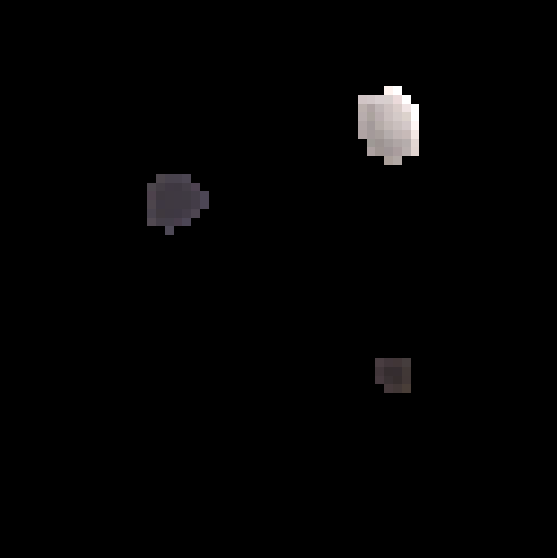

In [58]:
g_image_rsp = np.nanmedian(rsp_mod_cube__wyx[(G_WAVE[0]<=rsp_wave__w)&(rsp_wave__w<=G_WAVE[1])], axis=0)
g_image_rsp[~mask_img] = np.nan
r_image_rsp = np.nanmedian(rsp_mod_cube__wyx[(R_WAVE[0]<=rsp_wave__w)&(rsp_wave__w<=R_WAVE[1])], axis=0)
r_image_rsp[~mask_img] = np.nan
i_image_rsp = np.nanmedian(rsp_mod_cube__wyx[(I_WAVE[0]<=rsp_wave__w)&(rsp_wave__w<=I_WAVE[1])], axis=0)
i_image_rsp[~mask_img] = np.nan

# rgb_pointing = make_lupton_rgb(i_image_rsp, r_image_rsp, g_image_rsp, stretch=0.5, Q=5)
rgb_pointing = create_RGB(i_image_rsp, r_image_rsp, g_image_rsp)

fig, ax = plt.subplots(figsize=(10,10))
ax.set_aspect("equal")
ax.imshow(rgb_pointing, origin="lower")

# [ax.add_patch(region) for region in regions]

ax.axis("off")
fig.set_facecolor("#000")

# fig, ax = plt.subplots(figsize=(20,5))

# for i in range(len(regions)):
#     star_ix, star_iy = spaxels[masks[i]].T
#     # ax.step(org_wave__w, org_cube__wyx[:, star_iy, star_ix].sum(axis=-1), color="k", lw=1)
#     wl, fl = rsp_wave__w, np.nansum(rsp_mod_cube__wyx[:, star_iy, star_ix], axis=-1)
#     mask_norm = (WAVE_NORM[0]<=wl)&(wl<=WAVE_NORM[1])
#     fl /= fl[mask_norm].mean()
#     ax.step(wl, fl, color=regions[i].get_edgecolor(), lw=1)
# ax.set_xlim(3800,9500)

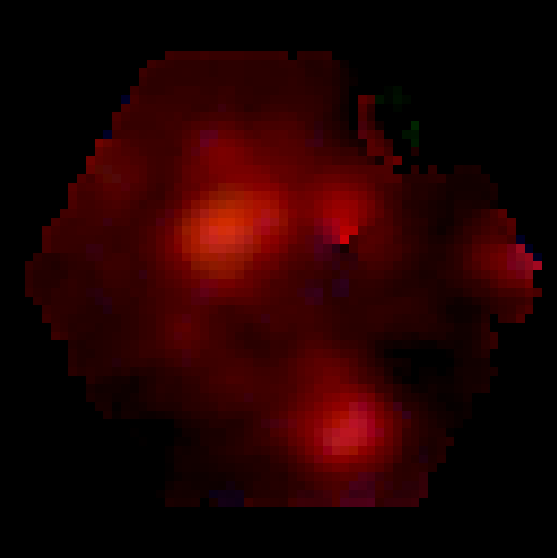

In [59]:
gas_mod = fits.open(os.path.join(OUTPUT_PATH,f"{POINTING}-gas.cube.fits.gz"), memmap=False)
gas_mod_cube__wyx = gas_mod[0].data
gas_wave__w = get_wave_from_header(gas_mod[0].header, wave_axis=3)

O_WAVE = 5006.84-5, 5006.84+5
H_WAVE = 6562.85-5, 6562.85+5
S_WAVE = 6716.44-5, 6730.82+5

o_image_gas = np.nanmedian(gas_mod_cube__wyx[(O_WAVE[0]<=gas_wave__w)&(gas_wave__w<=O_WAVE[1])], axis=0)
o_image_gas[~mask_img] = np.nan
h_image_gas = np.nanmedian(gas_mod_cube__wyx[(H_WAVE[0]<=gas_wave__w)&(gas_wave__w<=H_WAVE[1])], axis=0)
h_image_gas[~mask_img] = np.nan
s_image_gas = np.nanmedian(gas_mod_cube__wyx[(S_WAVE[0]<=gas_wave__w)&(gas_wave__w<=S_WAVE[1])], axis=0)
s_image_gas[~mask_img] = np.nan

# rgb_pointing = make_lupton_rgb(s_image_gas, h_image_gas, o_image_gas, stretch=0.5, Q=5)
rgb_pointing = create_RGB(h_image_gas, s_image_gas, o_image_gas)

fig, ax = plt.subplots(figsize=(10,10))
ax.set_aspect("equal")
ax.imshow(rgb_pointing, origin="lower")

# [ax.add_patch(region) for region in regions]

ax.axis("off")
fig.set_facecolor("#000")

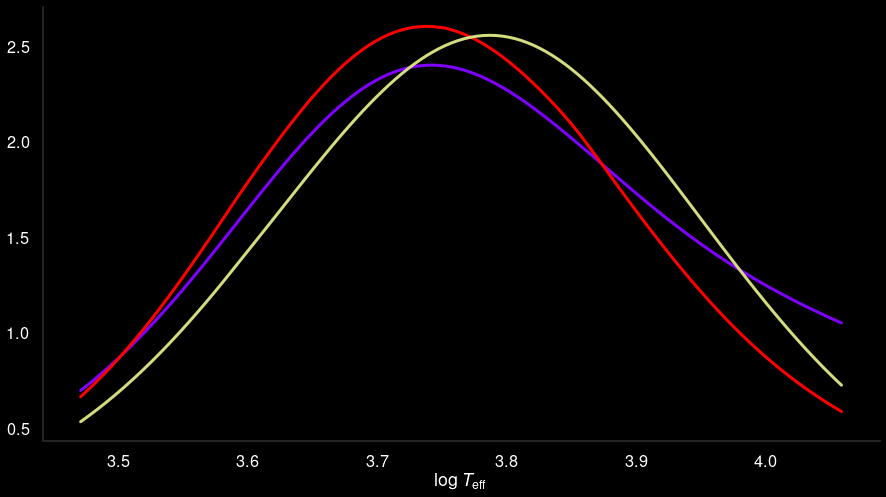

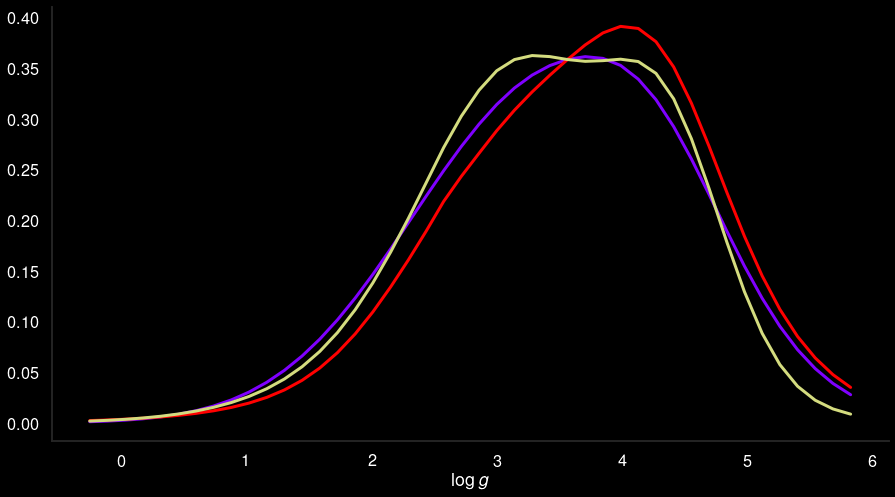

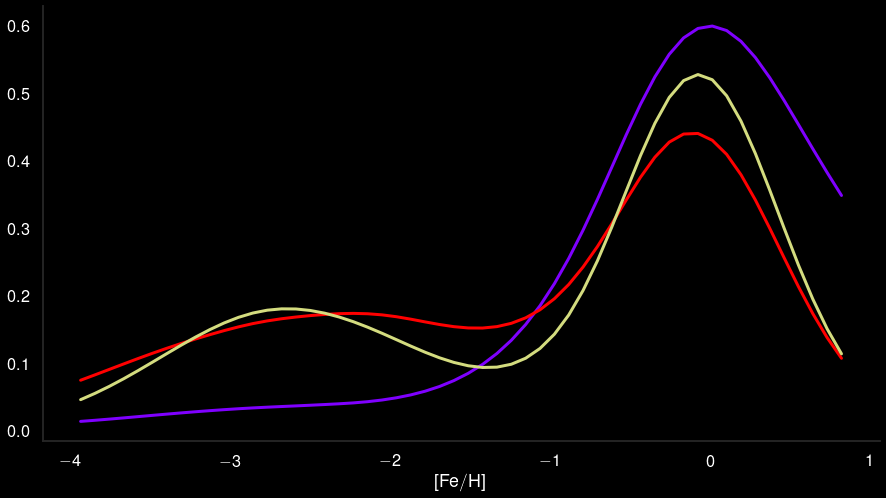

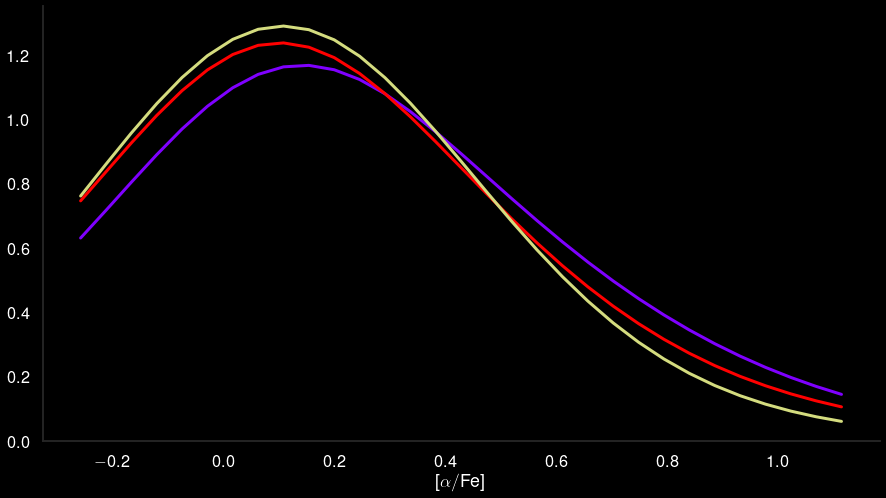

In [60]:
from matplotlib import rc


latex_preamble = "\n".join([
    r"\usepackage{helvet}",
    r"\usepackage{amsmath}",
    r"\usepackage[helvet]{sfmath}",
    r"\renewcommand{\familydefault}{\sfdefault}"
])

text = {"usetex":True, "latex.preamble":latex_preamble, "hinting":"native"}
rc("text", **text)

labels = {"TEFF":r"$\log{T_\text{eff}}$", "LOGG":r"$\log{g}$", "MET":r"$[\text{Fe}/\text{H}]$", "ALPHAM":r"$[\alpha/\text{Fe}]$"}

for j, name in enumerate(PARAM_NAMES):
    fig, ax = plt.subplots(figsize=(15,8))
    fig.set_facecolor("#000")
    ax.set_facecolor("#000")
    ax.tick_params(colors="w")
    for i in range(len(regions)):
        star_ix, star_iy = spaxels[masks[i]].T
        x, pdf = voxel_supp[name], cube_pdfs[name][:, star_iy, star_ix].sum(axis=-1)
        pdf = normalize_to_pdf(pdf, x)
        ax.plot(x, pdf, lw=3, color=regions[i].get_edgecolor())
        ax.set_xlabel(labels[name])
        # ax.tick_params("y", labelleft=False)
        ax.xaxis.label.set_color("w")
        sns.despine(ax=ax)